In [1]:
# Add utils libraries to program 
import sys
sys.path.append('/home/class_NI2021/ctxctl_contrib_2023')

# Imports all necessary libraries (samna and utils)
import samna
import samna.dynapse1 as dyn1
from dynapse1constants import *
import dynapse1utils as ut
import netgen as n
import params
import time
import math
import numpy as np

In [2]:
# Check which dynapse are free
devices = samna.device.get_unopened_devices()
for i in range(len(devices)):
        print("["+str(i)+"]: ", devices[i], "serial_number", devices[i].serial_number)

[0]:  Bus 1 Device 48 Dynapse1DevKit serial_number 00000007
[1]:  Bus 1 Device 50 Dynapse1DevKit serial_number 00000020
[2]:  Bus 1 Device 66 Dynapse1DevKit serial_number 00000011
[3]:  Bus 1 Device 65 Dynapse1DevKit serial_number 00000000


In [3]:
# Open DYNAP-SE1 board selected (by ports) and get Dynapse1Model, without GUI (GUI = False)
model, _ = ut.open_dynapse1(gui=False, sender_port=17349, receiver_port=15347, select_device=True) # dynapse = 11

ERROR: Address already in use, please re-run open_device()!
[0]:  Bus 1 Device 48 Dynapse1DevKit serial_number 00000007
[1]:  Bus 1 Device 50 Dynapse1DevKit serial_number 00000020
[2]:  Bus 1 Device 66 Dynapse1DevKit serial_number 00000011
[3]:  Bus 1 Device 65 Dynapse1DevKit serial_number 00000000
Sender port: tcp://0.0.0.0:17349
Receiver port: tcp://0.0.0.0:15347
Opened device name: Dynapse1DevKit
SamnaNode ID: 1
PythonNode ID: 2


In [4]:
# Needed functions
def get_bin_representation(input_ids):
    binary_ids = []
    max_num_digits = 0
    # Create a copy of input neurons ids to reverse and begin with the bigger one
    neurons_id = input_ids.copy()
    neurons_id.reverse()
    # For each neuron id
    for id in neurons_id:
        res = id
        binary_id = []
        # Calculate the binary representation
        while res > 1:
            binary_id.append(res % 2)
            res = res // 2
        if res == 0:
            binary_id.append(0)
        else:
            binary_id.append(1)
        # Adjust all binary representations to the number with the max number of digits
        if max_num_digits == 0:
            max_num_digits = len(binary_id)
        elif max_num_digits > len(binary_id):
            diff = max_num_digits - len(binary_id)
            for i in range(diff):
                binary_id.append(0)
        # Store the binary representation, the first element is the less significative and the last is the most significative (reverse the original representation)
        binary_ids.append(binary_id)
    binary_ids.reverse()
    return binary_ids

def get_syn_dg(input_neuron_ids):
    # Get binary representation
    binary_ids = get_bin_representation(list(range(1, 2**len(input_neuron_ids))))
    pre_exc_syn = []
    post_exc_syn = []
    pre_inh_syn = []
    post_inh_syn = []
    # Get pre and post inh and exc synapses from binary representation
    for post, binary_id in enumerate(binary_ids):
        for pre, id in enumerate(binary_id):
            if id == 0:
                pre_inh_syn.append(pre)
                post_inh_syn.append(post)
            else:
                pre_exc_syn.append(pre)
                post_exc_syn.append(post)

    return pre_exc_syn, post_exc_syn, pre_inh_syn, post_inh_syn

def get_all_2_all_weighted(dg_neuron_ids, post_inh_syn):
    pre_dg_inh_syn = []
    post_dg_inh_syn = []
    # Get all to all conn
    for pre in range(len(dg_neuron_ids)):
        for post in range(pre+1, len(dg_neuron_ids)):
            pre_dg_inh_syn.append(pre)
            post_dg_inh_syn.append(post)
    # Add extra conn to special cases (dg neurons with no inhbitions)
    #   - Get what neurons are not inhibited
    neurons_no_inhibition = [i for i in range(len(dg_neuron_ids)) if not (i in post_inh_syn)]
    neurons_with_inhibition = [i for i in range(len(dg_neuron_ids)) if i in post_inh_syn]
    #   - For each one of them, add extra synapses
    for no_inh_neuron in neurons_no_inhibition:
        # One extra synapses for each neuron that have inhibition
        for inh_neuron in neurons_with_inhibition:
            pre_dg_inh_syn.append(inh_neuron)
            post_dg_inh_syn.append(no_inh_neuron)

    return pre_dg_inh_syn, post_dg_inh_syn

In [7]:
# Initialization of all parameters
paramGroup = params.gen_clean_param_group()
for chip in range(4):
    for core in range(4):
        model.update_parameter_group(paramGroup, chip, core)

In [22]:
#   0 = 2 - 3 encoder
#   1 = 3 - 7 encoder
#   2 = 4 - 15 encoder
exp_id = 2

# To create a network:
#   1) Create populations of neurons (chip id, core id, neurons id, generator?)
#       Encoder 2 - (2^2) -> sin contar el 0 -> 2 - (2^2-1) -> 2 input - DG pop - 3 output
#           2 layers:
#               - layer 0 -> 2 neurons (1 exc input), 2 neurons (delay)
#               - layer 1 -> 1 neurons (2 exc input), 2 neurons (layer 0)
#       Encoder 3 - (2^3) -> sin contar el 0 -> 3 - (2^3-1) -> 3 input - DG pop - 7 output
#           3 layers:
#               - layer 0 -> 3 neurons (1 exc input), 3 neurons (delay)
#               - layer 1 -> 3 neurons (2 exc input), 3 neurons (delay), 3 neurons (layer 0)
#               - layer 2 -> 1 neuron (3 exc input), 6 neurons (layer 0 and 1)
#       - Spike generator 
if exp_id == 0:
    generator_neuron_ids = [1, 2]
elif exp_id == 1:
    generator_neuron_ids = [1, 2, 3]
elif exp_id == 2:
    generator_neuron_ids = [1, 2, 3, 4]
spikegen_pop = n.NeuronGroup(0 ,0, generator_neuron_ids, True)
#       - DG
dg_pop_chip = 0
dg_pop_core = 1
if exp_id == 0:
    # 7 neurons (2 layer 0 + 2 delay layer 0 + 1 layer 1 + 2 delay dg layer 1)
    delay_neurons_ids = [[1, 2], []] # neurons of Delay In pop in each layer
    dg_neuron_ids = [[3, 4], [7]] # neurons in DG pop in each layer
    delay_dg_neurons_ids = [[], [5, 6]] # neuron in Delay DG pop in each layer
    dg_neurons_index = [[0, 1], [2]] # index of neurons in DG pops if they has not layers
    out_neurons_index = [5, 6, 7] # neurons that are considered the result of the module
elif exp_id == 1:
    # 22 neurons (3 layer 0 + 3 delay layer 0 + 3 layer 1 + 3 delay layer 1 + 3 delay DG layer 1 + 1 layer 2 + 6 delay DG layer 2)
    delay_neurons_ids = [[1, 2, 3], [4, 5, 6], []] # neurons of Delay In pop in each layer
    dg_neuron_ids = [[7, 8, 9], [10, 11, 12], [22]] # neurons in DG pop in each layer
    delay_dg_neurons_ids = [[], [13, 14, 15], [16, 17, 19, 18, 20, 21]] # neuron in Delay DG pop in each layer
    dg_neurons_index = [[0, 1, 3], [2, 4, 5], [6]] # index of neurons in DG pops if they has not layers
    out_neurons_index = [16, 17, 18, 19, 20, 21, 22] # neurons that are considered the result of the module
elif exp_id == 2:
    # 55 neurons - 4 layer
    delay_neurons_ids = [[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12], []] # neurons of Delay In pop in each layer
    dg_neuron_ids = [[13, 14, 15, 16], [17, 18, 19, 20, 21, 22], [23, 24, 25, 26], [55]] # neurons in DG pop in each layer
    delay_dg_neurons_ids = [[], [27, 28, 29, 30], [31, 32, 33, 34, 35, 36, 37, 38, 39, 40], [41, 42, 44, 48, 43, 45, 46, 49, 50, 52, 47, 51, 53, 54]] # neuron in Delay DG pop in each layer
    dg_neurons_index = [[0, 1, 3, 7], [2, 4, 5, 8, 9, 11], [6, 10, 12, 13], [14]] # index of neurons in DG pops if they has not layers
    #dg_neurons_index = [[0, 1, 2, 3], [4, 5, 6, 7, 8, 9], [10, 11, 12, 13], [14]]
    out_neurons_index = [41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55] # neurons that are considered the result of the module
#               * DG
dg_pop = []
for neurons_id in dg_neuron_ids:
    if not(len(neurons_id) == 0):
        dg_pop.append(n.NeuronGroup(dg_pop_chip , dg_pop_core, neurons_id, False))
    else:
        dg_pop.append(False)
#               * Delay
delay_pop = []
for neurons_id in delay_neurons_ids:
    if not(len(neurons_id) == 0):
        delay_pop.append(n.NeuronGroup(dg_pop_chip , dg_pop_core, neurons_id, False))
    else:
        delay_pop.append(False)
#               * Delay DG
delay_dg_pop = []
for neurons_id in delay_dg_neurons_ids:
    if not(len(neurons_id) == 0):
        delay_dg_pop.append(n.NeuronGroup(dg_pop_chip , dg_pop_core, neurons_id, False))
    else:
        delay_dg_pop.append(False)


#   2) Create the network configuration for Dynapse (based on populations created and used to add synapses between them)
net_gen = n.NetworkGenerator()


#   3) Add synapses
#       - Calculate the excitatory and inhibitory synapses
pre_exc_syn, post_exc_syn, pre_inh_syn, post_inh_syn = get_syn_dg(generator_neuron_ids)
#       - IN-DELAY
in_delay_syn = n.Synapses(spikegen_pop, delay_pop[0], dyn1.Dynapse1SynType.AMPA, conn_type='one2one')
n.add_synapses(net_gen, in_delay_syn)
#       - DELAY-DELAY
delay_delay_syn = []
for i in range(1, len(generator_neuron_ids)-1):
    if not(len(delay_neurons_ids[i]) == 0):
        delay_delay_syn.append(n.Synapses(delay_pop[i-1], delay_pop[i], dyn1.Dynapse1SynType.AMPA, conn_type='one2one'))
        n.add_synapses(net_gen, delay_delay_syn[len(delay_delay_syn)-1])
#       - IN/Delay - DG
out_neurons = 0
for neurons_ids in dg_neuron_ids:
    out_neurons = out_neurons + len(neurons_ids)
for i in range(len(dg_pop)): 
    #   - Search synapses for each neuron to add
    exc_syn_per_out_neuron = []
    inh_syn_per_out_neuron = []
    for out_neuron in range(out_neurons):
        if post_exc_syn.count(out_neuron) == i+1:
            # exc
            indices = [index for index, post_neuron in enumerate(post_exc_syn) if post_neuron == out_neuron]
            post_syn_exc = []
            pre_syn_exc = []
            for index in indices:
                post_syn_exc.append(dg_neurons_index[i].index(post_exc_syn[index]))
                pre_syn_exc.append(pre_exc_syn[index])
            exc_syn_per_out_neuron.append([pre_syn_exc, post_syn_exc])
            # inh
            indices = [index for index, post_neuron in enumerate(post_inh_syn) if post_neuron == out_neuron]
            post_syn_inh = []
            pre_syn_inh = []
            for index in indices:
                post_syn_inh.append(dg_neurons_index[i].index(post_inh_syn[index]))
                pre_syn_inh.append(pre_inh_syn[index])
            inh_syn_per_out_neuron.append([pre_syn_inh, post_syn_inh])
    #   - Add synapses
    #       * Exc
    for neuron_syn_index in exc_syn_per_out_neuron:
        if i == 0:
            net_gen.add_connections_from_list(spikegen_pop.neurons, dg_pop[i].neurons, dyn1.Dynapse1SynType.AMPA, pre_ids = neuron_syn_index[0], post_ids = neuron_syn_index[1])
        else:
            net_gen.add_connections_from_list(delay_pop[i-1].neurons, dg_pop[i].neurons, dyn1.Dynapse1SynType.AMPA, pre_ids = neuron_syn_index[0], post_ids = neuron_syn_index[1])
    #       * Inh
    for neuron_syn_index in inh_syn_per_out_neuron:
        if i == 0:
            net_gen.add_connections_from_list(spikegen_pop.neurons, dg_pop[i].neurons, dyn1.Dynapse1SynType.GABA_B, pre_ids = neuron_syn_index[0], post_ids = neuron_syn_index[1])
        else:
            net_gen.add_connections_from_list(delay_pop[i-1].neurons, dg_pop[i].neurons, dyn1.Dynapse1SynType.GABA_B, pre_ids = neuron_syn_index[0], post_ids = neuron_syn_index[1])
#       - DG(layer i-1)-DG(layer i) inh
for i in range(len(dg_neuron_ids)):
    if not(i == 0):
        dg_dg_inh_syn = n.Synapses(dg_pop[i-1], dg_pop[i], dyn1.Dynapse1SynType.GABA_B, conn_type='all2all')
        n.add_synapses(net_gen, dg_dg_inh_syn)
for i in range(len(delay_dg_neurons_ids)):
    if not(i == 0) and not(type(delay_dg_pop[i-1]) is bool):
        dg_dg_inh_syn = n.Synapses(delay_dg_pop[i-1], dg_pop[i], dyn1.Dynapse1SynType.GABA_B, conn_type='all2all')
        n.add_synapses(net_gen, dg_dg_inh_syn)    
#       - DG(layer i-1)-DG delay(layer i) exc
#       - DG delay(layer i-1)-DG delay(layer i) exc
for i in range(len(dg_neuron_ids)):
    if not(i == 0) and not(type(delay_dg_pop[i-1]) is bool):
        net_gen.add_connections_from_list(delay_dg_pop[i-1].neurons, delay_dg_pop[i].neurons, dyn1.Dynapse1SynType.AMPA, 
                                        pre_ids = list(range(len(delay_dg_neurons_ids[i-1]))), 
                                        post_ids = list(range(len(delay_dg_neurons_ids[i-1]))))
    if not(i == 0):
        net_gen.add_connections_from_list(dg_pop[i-1].neurons, delay_dg_pop[i].neurons, dyn1.Dynapse1SynType.AMPA, 
                                        pre_ids = list(range(len(dg_neuron_ids[i-1]))), 
                                        post_ids = list(range(len(delay_dg_neurons_ids[i-1]), len(delay_dg_neurons_ids[i-1]) + len(dg_neuron_ids[i-1]))))


In [23]:
print("- Network: ")
print(net_gen.network)

- Network: 
Post neuron (ChipId,coreId,neuronId): incoming connections [(preNeuron,synapseType), ...]
C0c1n1: [('C0c0s1', 'AMPA')]
C0c1n2: [('C0c0s2', 'AMPA')]
C0c1n3: [('C0c0s3', 'AMPA')]
C0c1n4: [('C0c0s4', 'AMPA')]
C0c1n5: [('C0c1n1', 'AMPA')]
C0c1n6: [('C0c1n2', 'AMPA')]
C0c1n7: [('C0c1n3', 'AMPA')]
C0c1n8: [('C0c1n4', 'AMPA')]
C0c1n9: [('C0c1n5', 'AMPA')]
C0c1n10: [('C0c1n6', 'AMPA')]
C0c1n11: [('C0c1n7', 'AMPA')]
C0c1n12: [('C0c1n8', 'AMPA')]
C0c1n13: [('C0c0s1', 'AMPA'), ('C0c0s2', 'GABA_B'), ('C0c0s3', 'GABA_B'), ('C0c0s4', 'GABA_B')]
C0c1n14: [('C0c0s2', 'AMPA'), ('C0c0s1', 'GABA_B'), ('C0c0s3', 'GABA_B'), ('C0c0s4', 'GABA_B')]
C0c1n15: [('C0c0s3', 'AMPA'), ('C0c0s1', 'GABA_B'), ('C0c0s2', 'GABA_B'), ('C0c0s4', 'GABA_B')]
C0c1n16: [('C0c0s4', 'AMPA'), ('C0c0s1', 'GABA_B'), ('C0c0s2', 'GABA_B'), ('C0c0s3', 'GABA_B')]
C0c1n17: [('C0c1n1', 'AMPA'), ('C0c1n2', 'AMPA'), ('C0c1n3', 'GABA_B'), ('C0c1n4', 'GABA_B'), ('C0c1n15', 'GABA_B'), ('C0c1n13', 'GABA_B'), ('C0c1n16', 'GABA_B'), 

In [24]:
# Create configuration based on network created (if not valid raise an exception and close the device)
config = net_gen.make_dynapse1_configuration()

# Apply configuration
model.apply_configuration(config)

In [25]:
# Initialize custom parameters for a core and a chip:
paramGroup = dyn1.Dynapse1ParameterGroup() 

# PRE CORE
#   * coarse_value: to tune the parameters in a coarse way
#   * fine_value: to tune the parameters in a fine way
#   * param_name 
#       - Neuron:
#           * THR (IF_THR_N): the gain factor of neuron
paramGroup.param_map["IF_THR_N"].coarse_value = 5
paramGroup.param_map["IF_THR_N"].fine_value = 100
#           * RFR (IF_RFR_N): refractory period
paramGroup.param_map["IF_RFR_N"].coarse_value = 7
paramGroup.param_map["IF_RFR_N"].fine_value = 255
#           * TAU1 (IF_TAU1_N) and TAU2 (IF_TAU2_N): the membrane time-constant of leakage current or how much current is constantly leaked away
paramGroup.param_map["IF_TAU1_N"].coarse_value = 3
paramGroup.param_map["IF_TAU1_N"].fine_value = 15
#           * DC (IF_DC_P): injection of constant current
paramGroup.param_map["IF_DC_P"].coarse_value = 0
paramGroup.param_map["IF_DC_P"].fine_value = 0
#       - Synapses:
#           - AMPA (IE_F_P): Fast excitatory synapses
#               * TAU (NPDPIE_TAU_F_P or NPDPII_TAU_F_P)
paramGroup.param_map["NPDPIE_TAU_F_P"].coarse_value = 4
paramGroup.param_map["NPDPIE_TAU_F_P"].fine_value =  80
#               * THR (NPDPIE_THR_F_P or NPDPII_THR_F_P)
paramGroup.param_map["NPDPIE_THR_F_P"].coarse_value = 4
paramGroup.param_map["NPDPIE_THR_F_P"].fine_value =  80 
#               * WEIGHT (PS_WEIGHT_EXC_F_N or PS_WEIGHT_INH_F_N)
paramGroup.param_map["PS_WEIGHT_EXC_F_N"].coarse_value = 7
paramGroup.param_map["PS_WEIGHT_EXC_F_N"].fine_value = 255 
"""
#           - GABA_A (II_F_P): Fast inhibitory synapses
#               * TAU (NPDPIE_TAU_F_P or NPDPII_TAU_F_P)
paramGroup.param_map["NPDPII_TAU_F_P"].coarse_value = 2
paramGroup.param_map["NPDPII_TAU_F_P"].fine_value =  128 
#               * THR (NPDPIE_THR_F_P or NPDPII_THR_F_P)
paramGroup.param_map["NPDPII_THR_F_P"].coarse_value = 7
paramGroup.param_map["NPDPII_THR_F_P"].fine_value =  200
#               * WEIGHT (PS_WEIGHT_EXC_F_N or PS_WEIGHT_INH_F_N)
paramGroup.param_map["PS_WEIGHT_INH_F_N"].coarse_value = 7
paramGroup.param_map["PS_WEIGHT_INH_F_N"].fine_value = 255 
"""
paramGroup.param_map["NPDPII_TAU_S_P"].coarse_value = 2
paramGroup.param_map["NPDPII_TAU_S_P"].fine_value =  128 
paramGroup.param_map["NPDPII_THR_S_P"].coarse_value = 7
paramGroup.param_map["NPDPII_THR_S_P"].fine_value =  200
paramGroup.param_map["PS_WEIGHT_INH_S_N"].coarse_value = 7
paramGroup.param_map["PS_WEIGHT_INH_S_N"].fine_value = 255 

# Apply the custom parameters to the core
model.update_parameter_group(paramGroup, dg_pop[0].chip_id, dg_pop[0].core_id)

In [26]:
"""
Experiments:
    0 - test with ladder input
"""
experiment = 0

# Create the generator of spikes: set_fpga_spike_gen(*)
#   * generator object
fpga_spike_gen = model.get_fpga_spike_gen()
#   * list of input spikes in seconds = spike list
if experiment == 0:
    num_rep = 5
    if exp_id == 0:
        spike_time_list = np.sort(np.concatenate((np.linspace(0, 0.005, num_rep),
                                    np.linspace(0.1, 0.105, num_rep),
                                    np.linspace(0.2, 0.205, num_rep), np.linspace(0.2, 0.205, num_rep)), axis=None), axis=None)
        time_to_last_spike = 0.205
        total_time = 1
    elif exp_id == 1:
        spike_time_list = np.sort(np.concatenate((np.linspace(0, 0.005, num_rep),
                                    np.linspace(0.1, 0.105, num_rep),
                                    np.linspace(0.2, 0.205, num_rep), np.linspace(0.2, 0.205, num_rep),
                                    np.linspace(0.3, 0.305, num_rep),
                                    np.linspace(0.4, 0.405, num_rep), np.linspace(0.4, 0.405, num_rep),
                                    np.linspace(0.5, 0.505, num_rep), np.linspace(0.5, 0.505, num_rep),
                                    np.linspace(0.6, 0.605, num_rep), np.linspace(0.6, 0.605, num_rep), np.linspace(0.6, 0.605, num_rep)), axis=None), axis=None)
        time_to_last_spike = 0.605
        total_time = 1
    elif exp_id == 2:
        spike_time_list = np.sort(np.concatenate((np.linspace(0, 0.005, num_rep),
                                    np.linspace(0.1, 0.105, num_rep),
                                    np.linspace(0.2, 0.205, num_rep), np.linspace(0.2, 0.205, num_rep),
                                    np.linspace(0.3, 0.305, num_rep),
                                    np.linspace(0.4, 0.405, num_rep), np.linspace(0.4, 0.405, num_rep),
                                    np.linspace(0.5, 0.505, num_rep), np.linspace(0.5, 0.505, num_rep),
                                    np.linspace(0.6, 0.605, num_rep), np.linspace(0.6, 0.605, num_rep), np.linspace(0.6, 0.605, num_rep),
                                    np.linspace(0.7, 0.705, num_rep),
                                    np.linspace(0.8, 0.805, num_rep), np.linspace(0.8, 0.805, num_rep),
                                    np.linspace(0.9, 0.905, num_rep), np.linspace(0.9, 0.905, num_rep),
                                    np.linspace(1.0, 1.005, num_rep), np.linspace(1.0, 1.005, num_rep), np.linspace(1.0, 1.005, num_rep),
                                    np.linspace(1.1, 1.105, num_rep), np.linspace(1.1, 1.105, num_rep),
                                    np.linspace(1.2, 1.205, num_rep), np.linspace(1.2, 1.205, num_rep), np.linspace(1.2, 1.205, num_rep),
                                    np.linspace(1.3, 1.305, num_rep), np.linspace(1.3, 1.305, num_rep), np.linspace(1.3, 1.305, num_rep),
                                    np.linspace(1.4, 1.405, num_rep), np.linspace(1.4, 1.405, num_rep), np.linspace(1.4, 1.405, num_rep), np.linspace(1.4, 1.405, num_rep)),
                                      axis=None), axis=None)
        time_to_last_spike = 1.405
        total_time = 1.5
else:
    spike_time_list = []
    time_to_last_spike = 0
#   * list of generator neuron ids (one element per spike in spike list)
if experiment == 0:
    if exp_id == 0:
        gen_neuron_ids = ([1]*(num_rep) + [2]*(num_rep) + [1, 2]*(num_rep))
    elif exp_id == 1:
        gen_neuron_ids = ([1]*(num_rep) + [2]*(num_rep) + [1, 2]*(num_rep) 
                        + [3]*(num_rep) + [1, 3]*(num_rep) + [2, 3]*(num_rep)
                        + [1, 2, 3]*(num_rep))
    elif exp_id == 2:
        gen_neuron_ids = ([1]*(num_rep) + [2]*(num_rep) + [1, 2]*(num_rep) 
                        + [3]*(num_rep) + [1, 3]*(num_rep) + [2, 3]*(num_rep)
                        + [1, 2, 3]*(num_rep) + [4]*(num_rep) + [1, 4]*(num_rep)
                        + [2, 4]*(num_rep) + [1, 2, 4]*(num_rep) + [3, 4]*(num_rep)
                        + [1, 3, 4]*(num_rep) + [2, 3, 4]*(num_rep) + [1, 2, 3, 4]*(num_rep))
else:
    gen_neuron_ids = []
#   * list of chips where the post neurons are (one element per spike in spike list)
if experiment >= 0 and experiment <= 4:
    post_neuron_chips = [0]*len(spike_time_list)
else:
    post_neuron_chips = []
#   * isi_base = 90 or 900, scaled the inter spike interval for 1 or 10 us
isi_base = 900
#   * repeat_mode = loop on the spikes sends when finish the list
repeat_mode = False
# Set up the generator
ut.set_fpga_spike_gen(fpga_spike_gen, spike_time_list, gen_neuron_ids, post_neuron_chips, isi_base, repeat_mode)

In [27]:
if len(spike_time_list) < 50:
    print(spike_time_list)
    print(gen_neuron_ids)
else:
    print(len(spike_time_list))
    print(len(gen_neuron_ids))

160
160


In [28]:
# Get spikes of dynapse:
#   - Select the neurons to monitor
monitored_neurons = []
for pop in dg_pop:
    if not(type(pop) is bool):
        monitored_neurons = monitored_neurons + pop.tuple_neuron_ids
for pop in delay_pop:
    if not(type(pop) is bool):
        monitored_neurons = monitored_neurons + pop.tuple_neuron_ids
for pop in delay_dg_pop:
    if not(type(pop) is bool):
        monitored_neurons = monitored_neurons + pop.tuple_neuron_ids
graph, filter_node, sink_node = ut.create_neuron_select_graph(model, monitored_neurons)
#   - Start recording in graph
graph.start()
#   - Clear the buffer of input spike
sink_node.get_events()
#   - Start the spike generator
fpga_spike_gen.start()
#   - Wait to get events in buffer
time.sleep(time_to_last_spike)
fpga_spike_gen.stop()
time.sleep(total_time-time_to_last_spike)
#   - Get events from buffer
events = sink_node.get_events()
#   - Stop graph and generator
graph.stop()

True

In [29]:
print("- Events: " + str(len(events)))
timestamp_offset = 0
events_timestamp = []
events_neuron_id = []
out_events_timestamp = []
out_events_neuron_id = []
for event in events:
    if timestamp_offset == 0:
        timestamp_offset = event.timestamp
    # Get timestamp of event in ms from first spike
    timestamp_format_ms = (event.timestamp - timestamp_offset) * 1e-3
    # Round to up if >= x.5
    if timestamp_format_ms - int(timestamp_format_ms) >= 0.5:
        timestamp_format_ms = int(timestamp_format_ms) + 1
    else:
        timestamp_format_ms = int(timestamp_format_ms)
    # Print info
    if len(events) < 30:
        print("  * id=" + str(event.neuron_id) + " t=" + str(timestamp_format_ms) + " ms")
    # Divide events: inside and out/results
    if event.neuron_id in out_neurons_index:
        out_events_timestamp.append(timestamp_format_ms)
        out_events_neuron_id.append(event.neuron_id)
    else:
        events_timestamp.append(timestamp_format_ms)
        events_neuron_id.append(event.neuron_id)

- Events: 699


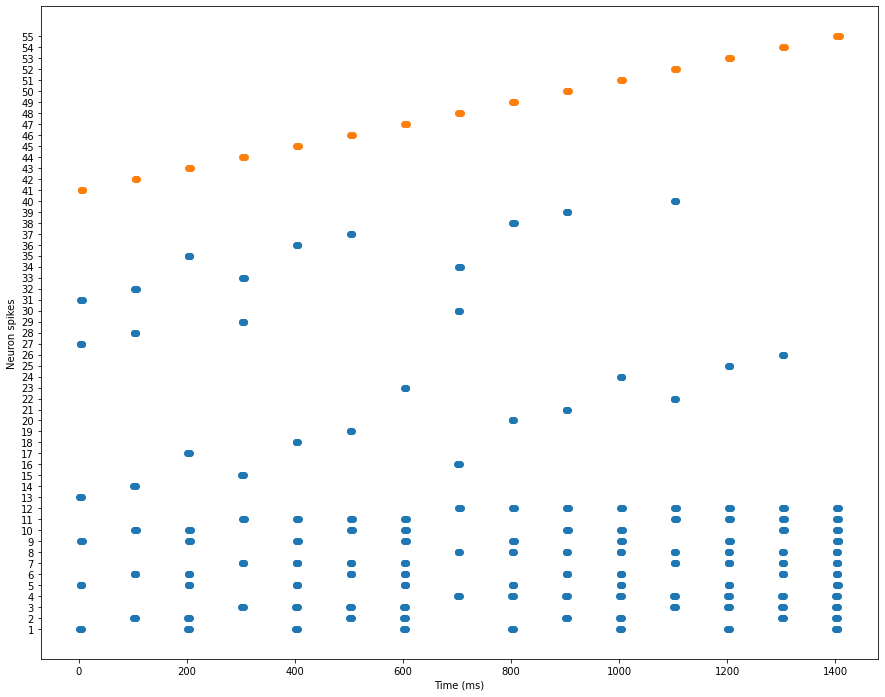

In [30]:
#if not(experiment == 5):
# Plot the spikes events in time 
import matplotlib.pyplot as plt

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'black'

plt.figure(figsize=(15,12))
#plt.ylim([0, 40])
plt.yticks(list(set(events_neuron_id + out_events_neuron_id)))
#plt.xticks(list(set(events_timestamp)))
#plt.xlim([-5, 15])

plt.xlabel("Time (ms)")
plt.ylabel("Neuron spikes")
plt.plot(events_timestamp, events_neuron_id,"o")
plt.plot(out_events_timestamp, out_events_neuron_id,"o")
plt.savefig("results/encoder_cascade_"+str(exp_id)+".png", bbox_inches='tight')
plt.show()

In [32]:
# Close the device
close = False
if close:
    samna.device.close_device(model)